In [7]:
import re
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pandas as pd

In [8]:
servic_key = "WMV3wl%2BU%2BMG%2FOYQK3Wv99q1H79wjvVwIwHEjvrDV3K4gG2h9P1%2BKiB%2FFa1QoYI0yxBpJ3sm1L0OAEam9Rp2sbw%3D%3D"
open_api = 'https://www.data.go.kr/dataset/3050988/openapi.do'

# train set / 201608 - 201708 1년 간의 은평구 아파트 매매
train_soup_items = []
locate_code = '11380'  # 서울 은평구
contract_date_start = '201608'
contract_date = ''

for i in range(13):
    if i < 5: 
        contract_date = str(int(contract_date_start)+i)
        print(contract_date)
        request_url = "http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade?LAWD_CD=" + locate_code + "&DEAL_YMD=" + contract_date + "&serviceKey=" + servic_key
        response = requests.get(request_url)
        soup = BeautifulSoup(response.content.decode('utf-8'), 'lxml')
        train_soup_items.append(soup.find_all('item'))
        
    else:
        contract_date = str(201701 + (i - 5))
        print(contract_date)
        request_url = "http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade?LAWD_CD=" + locate_code + "&DEAL_YMD=" + contract_date + "&serviceKey=" + servic_key
        response = requests.get(request_url)
        soup = BeautifulSoup(response.content.decode('utf-8'), 'lxml')
        train_soup_items.append(soup.find_all('item'))


201608
201609
201610
201611
201612
201701
201702
201703
201704
201705
201706
201707
201708


In [9]:
for item in train_soup_items:
    print(len(item)) 
    
# 월마다 거래량이 달라진 것을 확인 / 11월-4월 < 5-10월
# 월 숫자의 크기와 거래량은 선형적이지는 않음 : 카테고리 변수로 사용하는 것이 더 좋을 것으로 판단

326
363
403
213
148
120
195
235
260
350
332
364
196


In [10]:
# test set
locate_code = '11380'  # 서울 은평구, 
contract_date = '201709'

request_url2 = "http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade?LAWD_CD=" + locate_code + "&DEAL_YMD=" + contract_date + "&serviceKey=" + servic_key
response2 = requests.get(request_url2)
soup2 = BeautifulSoup(response2.content.decode('utf-8'), 'lxml')
test_soup_item = soup2.find_all('item')

In [11]:
len(test_soup_item)

# 작년 대비 9월 대비 거래량이 50% 미만 수준
# 거래량 또한 가격에 유의미한 변수일 수 있을 것으로 보고,
# 별도 변수를 생성.

174

In [12]:
train_yangcheon_list, test_yangcheon_list = [], []

In [13]:
for items in train_soup_items:
    
    for i, item in enumerate(items):
        
        row_data = []
        
        for info in item.text.split('>')[:-1]:
            row_data.append(info)
        
        train_yangcheon_list.append(row_data)

In [14]:
for item in enumerate(test_soup_item):
    
    row_data = []
    #print(item[1].text.split('&gt'))
    #print('')
    
    for j, sp in enumerate(item[1].text.split('&gt')[0].split('>')[:-1]):
        row_data.append(sp)

    test_yangcheon_list.append(row_data)

In [15]:
colnames = ['price', 'build_year', 'year', 'sector', 'apart', 'month', 'day', 'sqm', 'sector_code', 'post_code', 'floor']            
train_df = pd.DataFrame(train_yangcheon_list, columns=colnames) #3504개
test_df = pd.DataFrame(test_yangcheon_list, columns=colnames) #147개

# 원본 확인 위한 별도의 복사본 생성
df_for_test = train_df.copy()
df_for_test2 = test_df.copy()

In [16]:
train_df.head(3)

,price,build_year,year,sector,apart,month,day,sqm,sector_code,post_code,floor
0,"37,000거래금액",2003건축년도,2016년,수색동법정동,대림한숲아파트,8월,1~10일,84.95전용면적,415-1지번,11380지역코드,3층
1,"94,700거래금액",2009건축년도,2016년,수색동법정동,수색자이 1단지아파트,8월,11~20일,205.96전용면적,75지번,11380지역코드,19층
2,"31,500거래금액",2003건축년도,2016년,수색동법정동,대림한숲아파트,8월,11~20일,59.9전용면적,415-1지번,11380지역코드,5층


### 자료형 처리 자동화 함수를 작성
* 추후 동일한 api 소스에서 데이터를 불러올 때 사용한다.

In [17]:
def refine_apartment_data_datagokr(feature):
    
    #print('original feature')
    #print(feature[:3])
    
    refined_res = []
    
    # iterable에 있는 스트링 데이터 각각에 대하여.
    for value in feature:
        
        refined = ''
        
        # day가 아닐 때.
        if '~' not in value:
            
            # '법정동', '아파트' 항목이 아닐 때
            if ('법정동' not in value) and ('아파트' not in value):
        
                # 1글자씩 읽어서 공백과 문자열을 1차로 필터링
                for c in value:

                    try:
                        temp = int(c)
                        refined += c

                    except:

                        try:
                            temp = float(c)
                            refined += c

                        # sector_code의 '-', sqm의 '.'은 살리고자 함
                        except:
                            if c == '-' or c == '.':
                                refined += c
                            pass

                # 숫자로 변환 가능하면 숫자(1.int -> 2.float), 불가능하면 문자열로.
                try:

                    temp2 = int(refined)
                    refined_res.append(temp2)

                except:

                    try: 
                        temp2 = float(refined)
                        refined_res.append(temp2)

                    except:
                        refined_res.append(refined)
        
            # '법정동', '아파트' 항목일 때.
            else:

                if '법정동' in value:
                    # 공백이 있다면 제거
                    sector_refined = ''
                    for c in value:
                        if (c!=' '):
                            sector_refined += c
                    refined_res.append(sector_refined[:-3])

                else:
                    # 공백이 있다면 제거
                    # '아파트' 문자열도 제거한다.
                    apt_refined = ''
                    for c in value:

                        if (c != ' ') and (c not in ['아','파','트']):
                            apt_refined += c

                    refined_res.append(apt_refined)
                        
        # day에 해당할 때.
        else:
            refined_res.append(int(value[-3:-1]))
            
        
    return refined_res



In [18]:
# Test - Ok.

#for col in df_for_test.columns:
#    print('###')
#    print(refine_apartment_data_datagokr(df_for_test[col])[:3])
#    print('###')   

In [19]:
for col in df_for_test.columns:
    
    train_df[col] =\
                    refine_apartment_data_datagokr(df_for_test[col])
    test_df[col] =\
                    refine_apartment_data_datagokr(df_for_test2[col])

In [20]:
train_df.head()

,price,build_year,year,sector,apart,month,day,sqm,sector_code,post_code,floor
0,37000,2003,2016,수색동,대림한숲,8,10,84.95,415-1,11380,3
1,94700,2009,2016,수색동,수색자이1단지,8,20,205.96,75,11380,19
2,31500,2003,2016,수색동,대림한숲,8,20,59.90,415-1,11380,5
3,35000,2003,2016,수색동,진흥엣세벨,8,20,57.50,416-1,11380,11
4,42000,2003,2016,수색동,대림한숲,8,20,84.95,415-1,11380,13


In [21]:
for col in test_df.columns:
    
    print(col, test_df[col].dtype)
    

price int64
build_year int64
year int64
sector object
apart object
month int64
day int64
sqm float64
sector_code object
post_code int64
floor int64


# MySql database upload

In [23]:
db = pymysql.connect(host='127.0.0.1', port=3306, user='root', passwd='jy9442xf', db='crawling_db', charset='utf8')
cursor = db.cursor()
cursor.execute("set names utf8")

0

In [24]:
sql = '''
            DROP TABLE IF EXISTS estate_eunpyeong_201708;
            CREATE TABLE estate_eunpyeong_201708 (
                   id INT UNSIGNED NOT NULL AUTO_INCREMENT,
                   price INT(10) NOT NULL,
                   build_year INT(5) NOT NULL,
                   year INT(5) NOT NULL,
                   sector VARCHAR(10) NOT NULL,
                   apart VARCHAR(20) NOT NULL,
                   month INT(5) NOT NULL,
                   day INT(5) NOT NULL,
                   sqm FLOAT(10) NOT NULL,
                   sector_code VARCHAR(20) NOT NULL,
                   post_code INT(5) NOT NULL,
                   floor INT(5) NOT NULL,
                   PRIMARY KEY(id)
            ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
        '''
cursor.execute(sql)
db.commit()

In [25]:
for idx_row in range(len(train_df.price)):
    
    row = train_df.iloc[idx_row]
    
    # price, build_year, year, sector, apart, month, day, sqm, sector_code
    # post_code, floor
    
    
    sql = '''
        INSERT INTO estate_eunpyeong_201708 
            (price, build_year, year, sector, apart, month, day, sqm, sector_code, 
            post_code, floor)
        VALUES 
            (%d, '%d', '%d', '%s', '%s', '%d', '%d', '%f', '%s', '%d', '%d') 
    ''' % (row.price, row.build_year, row.year, row.sector, row.apart,\
          row.month, row.day, row.sqm, row.sector_code,\
          row.post_code, row.floor)
    #print(sql)
    
    cursor.execute(sql)
    db.commit()
    
    

In [26]:
db.close()

# Simple Linear Regression Model
* 2017년 은평구의 아파트 매매자료를 바탕으로 간단한 선형 모델을 만들어 본다.

### Model application
* 모델 학습에 사용할 데이터(train set) : 
  * locate_code = 11380
  * contract_date = 201608 - 201708
* 모델 테스트에 사용할 데이터(test set) : 
  * locate_code = 11380
  * contract_date = 201709

### Preprocess & feature engineering

In [28]:
train_df['price_per_sqm'] =\
                    train_df.price / train_df.sqm
    
test_df['price_per_sqm'] =\
                    test_df.price / test_df.sqm

In [29]:
train_df['yearmonth'] =\
                    train_df.year*100 + train_df.month
test_df['yearmonth'] =\
                    test_df.year*100 + test_df.month

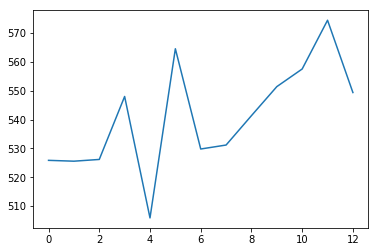

In [30]:
plt.plot(range(13), \
         train_df.groupby('yearmonth').price_per_sqm.mean())
plt.show()

In [31]:
train_df['build_age'] =\
                train_df.year -\
                train_df.build_year
        
test_df['build_age'] =\
                test_df.year -\
                test_df.build_year

In [32]:
train_df.groupby('yearmonth')['price'].count()

yearmonth
201608    326
201609    363
201610    403
201611    213
201612    148
201701    120
201702    195
201703    235
201704    260
201705    350
201706    332
201707    364
201708    196
Name: price, dtype: int64

In [33]:
train_sales = pd.Series(train_df.groupby('yearmonth')['price'].count())

In [35]:
train_df['sales_count'] = 0
for ym in train_df.yearmonth.unique():
    train_df['sales_count'][train_df.yearmonth == ym]\
            = train_sales.loc[ym]

/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
test_df['sales_count'] = test_df.groupby('yearmonth')['price'].count().values[0]

In [37]:
# apart의 경우, 유의미할 수 있으나 클래스가 374개로 매우 많은 편
# 374개의 더미 변수로 쪼개어 선형 모델에 적용하기에는 다소 무리가 있어 보인다.
len(train_df.apart.unique())

374

In [38]:
# 아파트별 평당 가격의 평균 top 10.
train_df.groupby('apart').price_per_sqm.mean().sort_values(ascending=False)[:10]

apart
주주베에이        996.459980
제이타워3        984.413454
응암네스         946.868825
제이타워1        916.604057
주주베B         908.850924
정익제이원(4차)    902.939923
YS홈타운        879.629630
정익제이원        871.247531
대경홈타운        870.195794
디오반          867.763288
Name: price_per_sqm, dtype: float64

In [39]:
# 평당 가격의 전체 평균으로 나눈 뒤 오름차순 정렬
train_df.groupby('apart').price_per_sqm.mean().sort_values()\
                                    / train_df.price_per_sqm.mean()

apart
무궁화                  0.416330
현재맨션                 0.485662
해오름                  0.491785
타워                   0.502024
명남빌라                 0.516943
우신                   0.518939
엘지                   0.524499
명남(200-16)           0.528584
남양구르미                0.539219
웰빙                   0.539304
현대                   0.540332
대암                   0.542802
인우(281-215)          0.546255
명성                   0.547811
역촌월드                 0.551051
청솔                   0.552598
명진(200-115)          0.554512
역촌맨션                 0.556402
역촌빌라                 0.556928
행운                   0.562921
태영홈                  0.566118
경향                   0.568135
두일                   0.570782
동익크(355-98)          0.578522
금강포란재(101)           0.581529
한름                   0.584961
동명베스(84-21)          0.591184
인우(281-236)          0.593046
대양                   0.595268
성현                   0.598106
                       ...   
은평뉴타운우물골(두산위브5단지)    1.294254
미르라이프                1.298163
북한산현

In [40]:
# (해당 아파트의 평균 평당가격 / 전체 아파트 평당 평당가격)으로 맵핑
# apart의 기존 datatype이 string(object)이므로, 새로 float형 column을 생성한다.

train_price_per_sqm_by_apart = train_df.groupby('apart').\
                                price_per_sqm.mean().sort_values()\
                                    / train_df.price_per_sqm.mean()

train_df['apartment'] = 0.0
test_df['apartment'] = 0.0
        
for apt in train_price_per_sqm_by_apart.index:
    
    train_df['apartment'][train_df.apart==apt] =\
                train_price_per_sqm_by_apart.loc[apt]
        
    # test_df에도 적용.
    if apt in test_df.apart.unique():
        test_df['apartment'][test_df.apart==apt] =\
                train_price_per_sqm_by_apart.loc[apt]
            

/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [41]:
# 아래 목록은 train set에서 거래된 적이 없는 아파트
# 실제 확인 결과 일부 아파트는 이름이 같으나 번지, 단지 숫자가 달라 다른 아파트로 판정되었음
excluded_apt = test_df.apart[test_df.apartment==0.0]
excluded_apt

10          해피플러스1
43              천지
59            한성산장
62         정익제이원6차
76             청안인
115    뉴서울(277-19)
117     뉴서울(277-2)
119       선정(35-2)
123            뉴월드
139        선정(178)
Name: apart, dtype: object

In [42]:
import numpy as np
apart_in_trainset = pd.Series(\
                refine_apartment_data_datagokr(df_for_test.apart)).unique()

In [43]:
# 앞에서 2글자가 같은 아파트 이름을 검색 후 출력
# 앞 2글자가 같은 경우를 찾지 못한 경우 법정동을 출력

for apt in excluded_apt:
    print(apt)
    
    similar = []
    
    for i, apt2 in enumerate(apart_in_trainset):
        
        if apt2.startswith(apt[:2]):
            print(apt, '-', apt2)
            similar.append(apt2)
            #test_df.apart[test_df.apart==apt] =\
            #        train_price_per_sqm_by_apart.loc[apt2]
        
        if i == (len(apart_in_trainset)-1) and len(similar) > 0:
            print(apt, '->', similar,'\n')
            break
        
    else:

        print(apt,'in the following sector:', test_df.sector[test_df.apart==apt].values,'\n')
        
        #test_df.apart[test_df.apart==apt] = np.NaN
    

해피플러스1
해피플러스1 in the following sector: ['불광동'] 

천지
천지 - 천지홈타운
천지 -> ['천지홈타운'] 

한성산장
한성산장 in the following sector: ['구산동'] 

정익제이원6차
정익제이원6차 - 정익제이원(15-114)
정익제이원6차 - 정익제이원(4차)
정익제이원6차 - 정익제이원
정익제이원6차 -> ['정익제이원(15-114)', '정익제이원(4차)', '정익제이원'] 

청안인
청안인 in the following sector: ['응암동'] 

뉴서울(277-19)
뉴서울(277-19) in the following sector: ['신사동'] 

뉴서울(277-2)
뉴서울(277-2) in the following sector: ['신사동'] 

선정(35-2)
선정(35-2) - 선정(348-12)
선정(35-2) - 선정(177)
선정(35-2) -> ['선정(348-12)', '선정(177)'] 

뉴월드
뉴월드 - 뉴월드(402-42)
뉴월드 - 뉴월드(402-112)
뉴월드 -> ['뉴월드(402-42)', '뉴월드(402-112)'] 

선정(178)
선정(178) - 선정(348-12)
선정(178) - 선정(177)
선정(178) -> ['선정(348-12)', '선정(177)'] 



In [44]:
# 해피플러스1 = 불광동 아파트 평균 평당가격 / 전체 법정동 아파트 평균 평당가격
# 한성산장 = 구산동 아파트 평균 평당가격 / 전체 법정동 아파트 평균 평당가격
# 청안인 = 응암동 아파트 평균 평당가격 / 전체 법정동 아파트 평균 평당가격
# 뉴서울(277-19, 277-2) = 신사동 아파트 평균 평당가격 / 전체 법정동 아파트 평균 평당가격

def get_average_price_per_sqm_by_sector(sectorname):
    return (train_df.groupby('sector').price.mean().loc[sectorname]/train_df.groupby('sector').price.mean().mean())

In [45]:
test_df.apartment[test_df.apart=='해피플러스1'] =\
            get_average_price_per_sqm_by_sector('불광동')
    
test_df.apartment[test_df.apart=='한성산장'] =\
            get_average_price_per_sqm_by_sector('구산동')
    
test_df.apartment[test_df.apart=='청안인'] =\
            get_average_price_per_sqm_by_sector('응암동')

test_df.apartment[test_df.apart == '뉴서울(277-19)'] =\
            get_average_price_per_sqm_by_sector('신사동')
test_df.apartment[test_df.apart == '뉴서울(277-2)'] =\
            get_average_price_per_sqm_by_sector('신사동')

/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [46]:
# 천지 = 천지홈타운
# 정익제이원6차 = 정익제이원(4차)
# 선정(35-2) = 선정(177)
# 선정(178) = 선정(177)

train_price_per_sqm_by_apart

test_df.apartment[test_df.apart=='천지'] =\
            train_price_per_sqm_by_apart.loc['천지홈타운']
    
test_df.apartment[test_df.apart=='정익제이원6차'] =\
            train_price_per_sqm_by_apart.loc['정익제이원(4차)']

test_df.apartment[test_df.apart=='선정(35-2)'] =\
            train_price_per_sqm_by_apart.loc['선정(177)']
test_df.apartment[test_df.apart=='선정(178)'] =\
            train_price_per_sqm_by_apart.loc['선정(177)']

/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/choigww/anaconda/lib/python3.5/site-p

In [47]:
# sector의 경우에도 최초 string 타입으로 생성됨
# 새로 int 타입의 칼럼 sector_num을 생성
# (문자열 class value를 숫자값으로 변환)

train_df['sector_num'] = 0
test_df['sector_num'] = 0

for i, cname in enumerate(test_df.sector.unique()):
    
    train_df['sector_num'][train_df.sector==cname] = i+1
    test_df['sector_num'][test_df.sector==cname] = i+1

/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/choigww/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [48]:
train_df.sector.values
train_df.sector_num.values

array([ 1,  1,  1, ..., 11, 11, 11])

### 전처리 종료, trainset(201608-201708)으로 모델링 시작.

In [51]:
import statsmodels.api as sm
import seaborn as sns
import scipy as sp

# correlation check and feature selection
* X features
  * (continuous) = 'sqm', 'floor', 'build_age', 'apart'
  * (category) = 'month', 'sector'
* y feature = 'price'

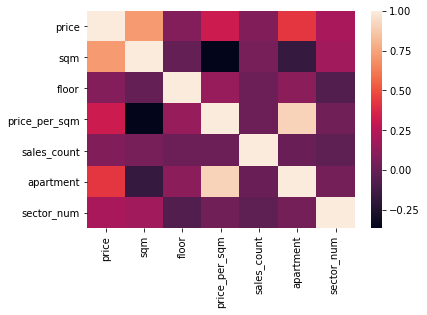

In [50]:
sns.heatmap(train_df\
            .drop(['year', 'day','post_code', 'build_year', 'build_age', 'yearmonth', 'month'],axis=1)\
            .corr())
plt.show()

In [53]:
def display_boxplot(df, feature):
    with plt.style.context(('seaborn-white')):
        plt.figure(figsize=(7, 5))
        sns.boxplot(x=df[feature], y=df['price'], linewidth=2, palette="Set1")
  

In [52]:
def get_unique_arr(df, feature):
    tmp_list = df[feature].unique()
    arr_list = []
    
    for i in range(len(tmp_list)):
        
        if type(tmp_list[i]) == str:
            exec("array = df['price'][df['%s'] == '%s'].values" % (feature, tmp_list[i]))
        else:
            exec("array = df['price'][df['%s'] == %d].values" % (feature, tmp_list[i]))
        exec("arr_list.append(array)")

    return arr_list

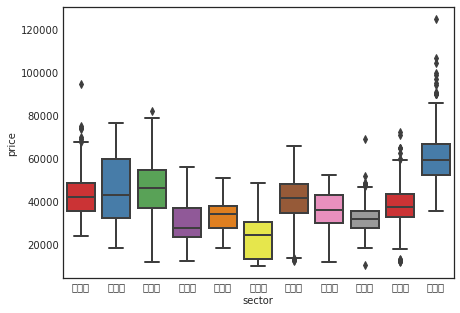

In [55]:
display_boxplot(train_df,'sector')
plt.show()

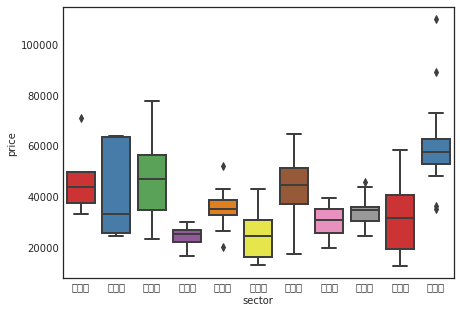

In [56]:
display_boxplot(test_df, 'sector')
plt.show()

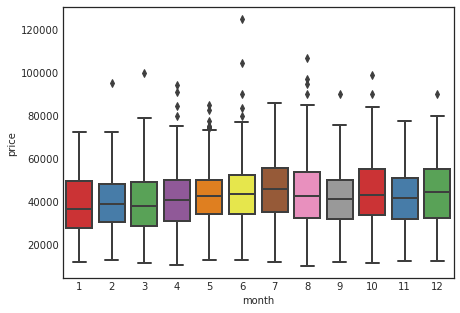

In [57]:
display_boxplot(train_df, 'month')
plt.show()

# F-Anova oneway

In [58]:
arr = get_unique_arr(train_df,'month')
print(len(arr))

for ar in arr:
    print(len(ar), end=' ')

print('')

# p_value < 0.05, check
print(sp.stats.f_oneway(arr[0], arr[1], arr[2], arr[3], arr[4], arr[5], arr[6],\
                       arr[7], arr[8], arr[9], arr[10], arr[11]))

12
522 363 403 213 148 120 195 235 260 350 332 364 
F_onewayResult(statistic=6.1265662593894321, pvalue=4.857511373669435e-10)


In [59]:
arr = get_unique_arr(train_df,'sector_num')
print(len(arr))

for ar in arr:
    print(len(ar), end=' ')

print('')

# p_value < 0.05, check
print(sp.stats.f_oneway(arr[0], arr[1], arr[2], arr[3], arr[4], arr[5], arr[6],\
                       arr[7], arr[8], arr[9], arr[10]))

11
166 202 610 180 181 127 681 135 403 163 657 
F_onewayResult(statistic=337.93482913428505, pvalue=0.0)


In [60]:
# build_age에 0값이 있는지 갯수 체크

print(len(train_df.build_age[train_df.build_age == 0]))
print(len(test_df.build_age[test_df.build_age == 0]))

11
4


In [61]:
# build_age에 0값이 존재하여 이후 log를 취할 수 없을 수 있음
# build_age의 모든 value에 0.1을 더해준다.

train_df.build_age += 0.01
test_df.build_age += 0.01

print(len(test_df.build_age[test_df.build_age == 0]))
print(len(train_df.build_age[train_df.build_age == 0]))

0
0


# first modeling
* R-squared = 0.935 (0-1, 1일 때 예측값=실제값)
* AIC/BIC = -6581/-6421 (작을수록 좋음)
* Cond. No. = 25.9 (0-무한, 작을수록 좋음)

In [62]:
# 이상값 / NaN값 체크.
# floor 2233번째에 이상값 -1 존재 : 1의 오타로 간주하고 1로 변경
for col in train_df[['sqm', 'floor', 'apartment', 'build_age', 'sector_num', 'month']].columns:
    
    print(col)
    print(train_df[col][train_df[col]<=0])
    print(train_df[col][train_df[col].isnull()])    
    

sqm
Series([], Name: sqm, dtype: float64)
Series([], Name: sqm, dtype: float64)
floor
2233   -1
Name: floor, dtype: int64
Series([], Name: floor, dtype: int64)
apartment
Series([], Name: apartment, dtype: float64)
Series([], Name: apartment, dtype: float64)
build_age
Series([], Name: build_age, dtype: float64)
Series([], Name: build_age, dtype: float64)
sector_num
Series([], Name: sector_num, dtype: int64)
Series([], Name: sector_num, dtype: int64)
month
Series([], Name: month, dtype: int64)
Series([], Name: month, dtype: int64)


In [63]:
train_df.floor.iloc[2233] = 1

/Users/choigww/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [64]:
X0 = train_df[['sqm', 'floor', 'apartment', 'build_age', 'sector_num', 'month']]
y = train_df.price

X = sm.add_constant(X0)
model = sm.OLS.from_formula("np.log(y) ~ scale(np.log(sqm))+\
                                scale(np.log(floor))+\
                                scale(build_age)+\
                                scale(apartment)+\
                                C(month)+\
                                C(sector_num)",\
                           data=X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              np.log(y)   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     2000.
Date:                Fri, 10 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:50:17   Log-Likelihood:                 3316.7
No. Observations:                3505   AIC:                            -6581.
Df Residuals:                    3479   BIC:                            -6421.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.6033      0.011    944.506      0.000      10.581      10.625
C(month)[T.2]            0.0325      0.011      2.958      0.003       0.011       0.054
C(month)[T.3]            0.0161      0.011      1.516      0.130      -0.005       0.037
C(month)[T.4]            0.0294      0.010      2.808      0.005       0.009       0.050
C(month)[T.5]            0.0539      0.010      5.366      0.000       0.034       0.074
C(month)[T.6]            0.0572      0.010      5.659      0.000       0.037       0.077
C(month)[T.7]            0.0682      0.010      6.829      0.000       0.049       0.088
C(month)[T.8]            0.0142      0.010      1.477      0.140      -0.005       0.033
C(month)[T.9]            0.0087      0.010      0.864      0.387      -0.011       0.028
C(month)[T.10]           0.0081      0.010      0.814      0.416      -0.011       0.027
C(month)[T.11]           0.0230      0.011      2.129      0.033       0.002       0.044
C(month)[T.12]          -0.0178      0.012     -1.523      0.128      -0.041       0.005
C(sector_num)[T.2]      -0.0188      0.010     -1.898      0.058      -0.038       0.001
C(sector_num)[T.3]       0.0173      0.008      2.057      0.040       0.001       0.034
C(sector_num)[T.4]      -0.1165      0.011    -11.025      0.000      -0.137      -0.096
C(sector_num)[T.5]      -0.0920      0.011     -8.738      0.000      -0.113      -0.071
C(sector_num)[T.6]      -0.1816      0.012    -14.858      0.000      -0.206      -0.158
C(sector_num)[T.7]      -0.0364      0.008     -4.395      0.000      -0.053      -0.020
C(sector_num)[T.8]      -0.0797      0.011     -7.098      0.000      -0.102      -0.058
C(sector_num)[T.9]      -0.0674      0.009     -7.545      0.000      -0.085      -0.050
C(sector_num)[T.10]     -0.0349      0.010     -3.333      0.001      -0.055      -0.014
C(sector_num)[T.11]      0.0524      0.009      6.129      0.000       0.036       0.069
scale(np.log(sqm))       0.3079      0.002    142.793      0.000       0.304       0.312
scale(np.log(floor))     0.0270      0.002     16.475      0.000       0.024       0.030
scale(build_age)        -0.0302      0.002    -12.335      0.000      -0.035      -0.025
scale(apartment)         0.1780      0.003     59.373      0.000       0.172       0.184
==============================================================================
Omnibus:                      253.065   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.652
Skew:                          -0.572   Prob(JB):                     8.99e-86
Kurtosis:                       4.171   Cond. No.                         25.9
==============================================================================

Warnings:
[1] Standard Erro

### Partial Regression Grid
* scaling / log application

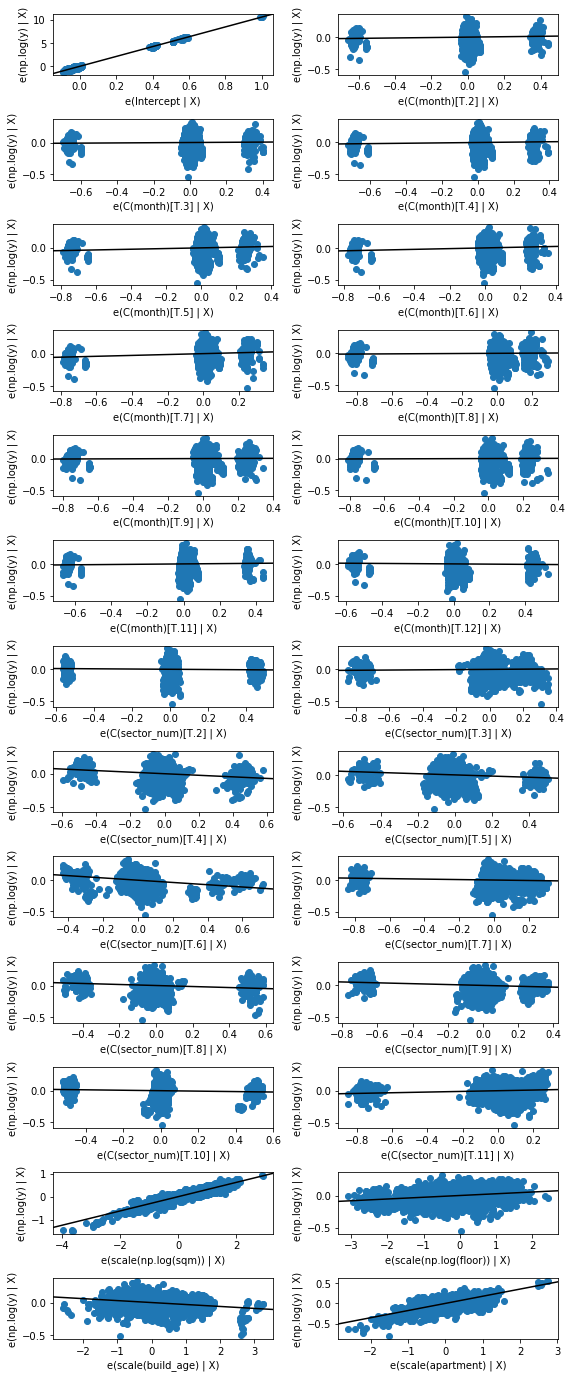

In [66]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# second modeling
* 다중회귀모형으로부터 새로운 y 예측값을 생성

In [67]:
X0_2 = train_df[['sqm', 'floor', 'build_age', 'apartment']]
y_2 = train_df.price

X_2 = sm.add_constant(X0_2)
model2 = sm.OLS.from_formula("np.log(y_2) ~ X_2+I(X_2**2)+I(X_2**3)",\
                           data=X_2)
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(y_2)   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     5090.
Date:                Fri, 10 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:52:10   Log-Likelihood:                 3640.1
No. Observations:                3505   AIC:                            -7254.
Df Residuals:                    3492   BIC:                            -7174.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.7617      0.020     88.333      0.000       1.723       1.801
X_2[0]             1.7617      0.020     88.333      0.000       1.723       1.801
X_2[1]             0.0494      0.001     54.505      0.000       0.048       0.051
X_2[2]             0.0205      0.003      7.935      0.000       0.015       0.026
X_2[3]             0.0050      0.002      3.205      0.001       0.002       0.008
X_2[4]             1.5838      0.200      7.900      0.000       1.191       1.977
I(X_2 ** 2)[0]     1.7617      0.020     88.333      0.000       1.723       1.801
I(X_2 ** 2)[1]    -0.0004   9.64e-06    -37.540      0.000      -0.000      -0.000
I(X_2 ** 2)[2]    -0.0015      0.000     -5.371      0.000      -0.002      -0.001
I(X_2 ** 2)[3]    -0.0003   8.34e-05     -3.647      0.000      -0.000      -0.000
I(X_2 ** 2)[4]     0.1351      0.194      0.697      0.486      -0.245       0.515
I(X_2 ** 3)[0]     1.7617      0.020     88.333      0.000       1.723       1.801
I(X_2 ** 3)[1]  9.649e-07   3.23e-08     29.902      0.000    9.02e-07    1.03e-06
I(X_2 ** 3)[2]   3.72e-05    9.3e-06      4.001      0.000     1.9e-05    5.54e-05
I(X_2 ** 3)[3]  3.665e-06   1.36e-06      2.696      0.007    9.99e-07    6.33e-06
I(X_2 ** 3)[4]    -0.2748      0.061     -4.533      0.000      -0.394      -0.156
==============================================================================
Omnibus:                       47.948   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.215
Skew:                           0.059   Prob(JB):                     5.16e-19
Kurtosis:                       3.750   Cond. No.                     7.39e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.43e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# third modeling
* 최초 모델의 target y value를 다중회귀모형 예측값으로 변경
* 성능의 개선을 확인.


|original model|advanced model
---|:---:|:---:
r-squared|0.935|0.970
AIC|-6578|-9469
BIC|-6417|-9309
Cond.No.|25.9|25.9

In [68]:
X0_3 = train_df[['sqm', 'floor', 'build_age', 'apartment','sector_num','month']]
y_3 = result2.predict(X_2)

X_3 = sm.add_constant(X0)
model_3 = sm.OLS.from_formula("(y_3) ~ scale(np.log(sqm))+\
                                scale(np.log(floor))+\
                                scale(build_age)+\
                                scale(apartment)+\
                                C(month)+\
                                C(sector_num)",\
                           data=X_3)
result_3 = model_3.fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_3   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     4474.
Date:                Fri, 10 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:52:34   Log-Likelihood:                 4760.5
No. Observations:                3505   AIC:                            -9469.
Df Residuals:                    3479   BIC:                            -9309.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.6319      0.007   1429.790      0.000      10.617      10.646
C(month)[T.2]            0.0161      0.007      2.213      0.027       0.002       0.030
C(month)[T.3]            0.0052      0.007      0.740      0.460      -0.009       0.019
C(month)[T.4]            0.0067      0.007      0.969      0.332      -0.007       0.020
C(month)[T.5]            0.0201      0.007      3.013      0.003       0.007       0.033
C(month)[T.6]            0.0127      0.007      1.898      0.058      -0.000       0.026
C(month)[T.7]            0.0160      0.007      2.414      0.016       0.003       0.029
C(month)[T.8]            0.0127      0.006      1.997      0.046       0.000       0.025
C(month)[T.9]            0.0120      0.007      1.807      0.071      -0.001       0.025
C(month)[T.10]           0.0072      0.007      1.105      0.269      -0.006       0.020
C(month)[T.11]           0.0044      0.007      0.619      0.536      -0.010       0.018
C(month)[T.12]          -0.0043      0.008     -0.558      0.577      -0.019       0.011
C(sector_num)[T.2]      -0.0381      0.007     -5.794      0.000      -0.051      -0.025
C(sector_num)[T.3]      -0.0152      0.006     -2.723      0.007      -0.026      -0.004
C(sector_num)[T.4]      -0.0991      0.007    -14.161      0.000      -0.113      -0.085
C(sector_num)[T.5]      -0.0874      0.007    -12.531      0.000      -0.101      -0.074
C(sector_num)[T.6]      -0.1484      0.008    -18.337      0.000      -0.164      -0.133
C(sector_num)[T.7]      -0.0209      0.005     -3.798      0.000      -0.032      -0.010
C(sector_num)[T.8]      -0.0627      0.007     -8.436      0.000      -0.077      -0.048
C(sector_num)[T.9]      -0.0306      0.006     -5.183      0.000      -0.042      -0.019
C(sector_num)[T.10]     -0.0271      0.007     -3.902      0.000      -0.041      -0.013
C(sector_num)[T.11]     -0.0308      0.006     -5.433      0.000      -0.042      -0.020
scale(np.log(sqm))       0.3271      0.001    229.049      0.000       0.324       0.330
scale(np.log(floor))     0.0212      0.001     19.574      0.000       0.019       0.023
scale(build_age)        -0.0266      0.002    -16.407      0.000      -0.030      -0.023
scale(apartment)         0.2028      0.002    102.149      0.000       0.199       0.207
==============================================================================
Omnibus:                     1195.997   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5719.269
Skew:                          -1.574   Prob(JB):                         0.00
Kurtosis:                       8.408   Cond. No.                         25.9
==============================================================================

Warnings:
[1] Standard Erro

### Partial Regression for 3rd model

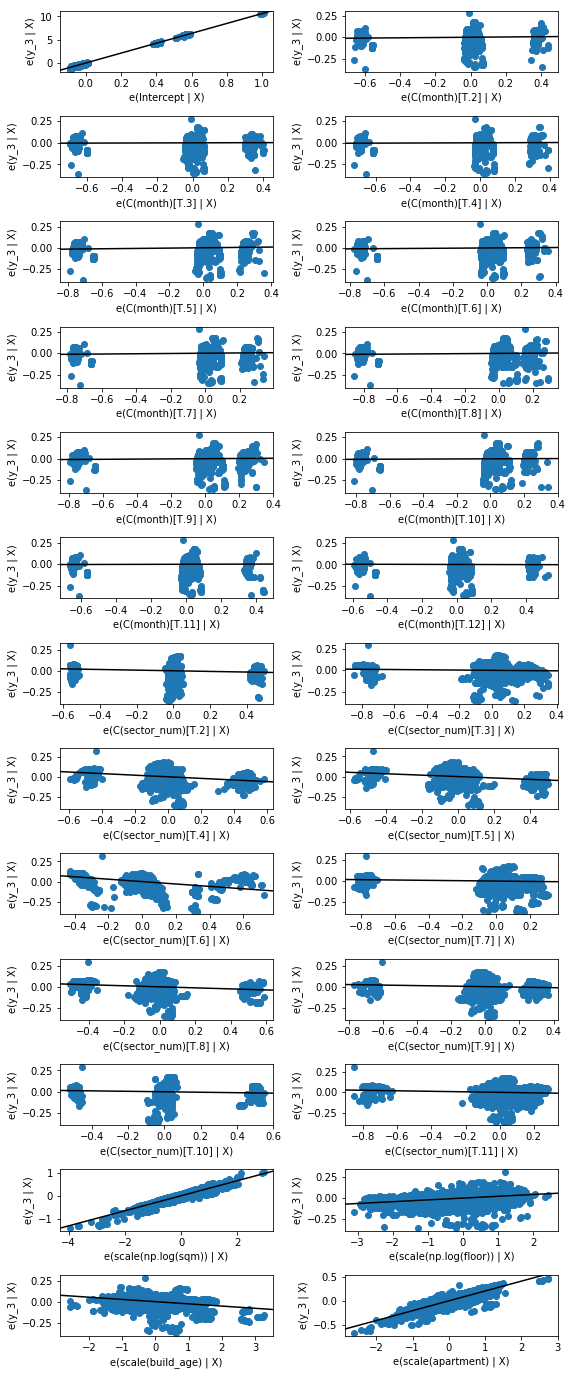

In [69]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result_3, fig=fig)
fig.suptitle("")
plt.show()

# Real price(purple) vs. Predicted (red)

In [70]:
len(train_df.price)

3505

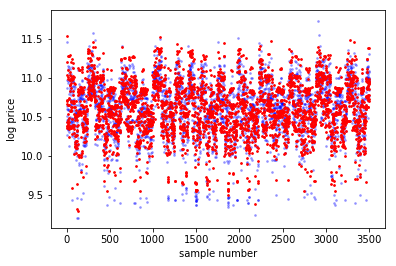

In [72]:
xx = np.linspace(0, 3505, 3505)
plt.scatter(xx,np.log(train_df.price), c='b', alpha=0.3, s=3)
plt.scatter(xx,result_3.predict(X), c='r', s=3)
plt.xlabel('sample number')
plt.ylabel('log price')
plt.show()

# Cross-validation
* train : test = 0.7 : 0.3
* perform 200 tries

In [73]:
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

/Users/choigww/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
cross_val_rsquare = []
cross_val_AIC = []
cross_val_BIC = []
cross_val_CN = []

for i in range(200):

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X0, y, test_size=0.3, random_state=i)

    X_t = sm.add_constant(X_train)
    X2_t = sm.add_constant(X_train.drop(['sector_num','month'], axis=1))
    y_t = y_train
    
    X_tt = sm.add_constant(X_test)
    y_tt = y_test
    
    model_p = sm.OLS.from_formula("np.log(y_t) ~ X2_t+I(X2_t**2)+I(X2_t**3)"\
                                    , data=X2_t)
    
    result_p = model_p.fit()
    
    y_pred = result_p.predict(X_t.drop(['sector_num', 'month'], axis=1))
    
    model_t = sm.OLS.from_formula("y_pred ~ scale(np.log(sqm))+\
                                scale(np.log(floor))+\
                                scale(build_age)+\
                                scale(apartment)+\
                                C(month)+\
                                C(sector_num)",\
                                   data=X_t)
    result_t = model_t.fit()

    cross_val_rsquare.append(result_t.rsquared)
    cross_val_AIC.append(result_t.aic)
    cross_val_BIC.append(result_t.bic)
    cross_val_CN.append(result_t.condition_number)


In [75]:
print(np.mean(cross_val_rsquare))
print(np.mean(cross_val_AIC))
print(np.mean(cross_val_BIC))
print(np.mean(cross_val_CN))

0.969872983211
-6617.67449559
-6466.74275244
25.9366479537


# Rough Result from Cross Validation

|original model|advanced model|advanced_CV(200)
---|:---:|:---:|:---:
r-squared|0.935|0.970|0.969
AIC|-6581|-9469|-6617
BIC|-6421|-9309|-6466
Cond.No.|25.9|25.9|25.93

* Cross validation 이전과 대비하여 모델 성능 지표의 소폭 하락이 나타남
* Cond.No.는 30 미만으로 다중공선성이 나타나지 않는 것으로 판단됨

# Predict & Conclusion


## 16.08-17.08 학습 모델로 17.09 아파트 매매가 예측
### R square = 0.948

* (예측값 - 실제값 평균)의 제곱합 / (실제값 - 실제값 평균)의 제곱합 = 0.948
* 학습한 모델의 교차검증 성능(r2 = 0.969)에 비해 0.02 가량 하락
  * 미미한 수준의 overfit으로 판단, 위 모델을 채택한다.

In [77]:
y_201709 = test_df.price
y_201709_bar = y_201709.mean()
y_201709_hat = np.exp(result_3.predict(test_df))

SST = ((y_201709 - y_201709_bar)**2).sum()
SSReg = ((y_201709_hat - y_201709_bar)**2).sum()
R2_201709 = SSReg/SST

R2_201709

0.948050107316847

# Test Dataframe에 예측가 column 추가 => 직접 확인.

In [80]:
test_df.insert(loc=1, column='price_predict', value = np.exp(result_3.predict(test_df)))

test_df

,price,price_predict,build_year,year,sector,apart,month,day,sqm,sector_code,post_code,floor,price_per_sqm,yearmonth,build_age,sales_count,apartment,sector_num
0,33000,31647.850185,2003,2017,수색동,대림한숲,9,10,59.90,415-1,11380,3,550.918197,201709,14.01,174,0.961669,1
1,43500,43844.993076,2003,2017,수색동,대림한숲,9,30,84.95,415-1,11380,6,512.065921,201709,14.01,174,0.961669,1
2,49500,57954.568025,2003,2017,수색동,대림한숲,9,30,114.18,415-1,11380,12,433.526012,201709,14.01,174,0.961669,1
3,37500,32434.994057,2003,2017,수색동,대림한숲,9,30,59.90,415-1,11380,7,626.043406,201709,14.01,174,0.961669,1
4,71000,64896.326916,2009,2017,수색동,수색자이1단지,9,30,123.67,75,11380,16,574.108515,201709,8.01,174,0.978642,1
5,33000,31739.643810,2002,2017,녹번동,녹번JR,9,20,59.87,280-1,11380,10,551.194254,201709,15.01,174,0.973330,2
6,25700,27968.303204,2005,2017,녹번동,청솔,9,20,78.33,71-8,11380,6,328.099068,201709,12.01,174,0.552598,2
7,63700,61424.660400,2015,2017,녹번동,북한산푸르지오,9,20,84.99,281,11380,20,749.499941,201709,2.01,174,1.313752,2
8,24500,25674.978678,2013,2017,녹번동,월든힐스,9,30,64.78,29-106,11380,5,378.203149,201709,4.01,174,0.621754,2
9,63400,60792.685757,2015,2017,녹번동,북한산푸르지오,9,30,84.99,281,11380,14,745.970114,201709,2.01,174,1.313752,2


### end of document